<a href="https://colab.research.google.com/github/Alfikriangelo/DeepLearningTasks/blob/main/UAS/CHAPTER_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 3: Classification**

**MNIST**

Dalam bab ini kita akan menggunakan dataset MNIST, yaitu sekumpulan 70.000 gambar kecil berupa digit angka yang ditulis tangan oleh siswa sekolah menengah atas dan karyawan Biro Sensus Amerika Serikat. Setiap gambar diberi label sesuai dengan digit yang diwakilinya. Dataset ini telah begitu banyak diteliti sehingga sering disebut sebagai “hello world”-nya *Machine Learning*: setiap kali orang menemukan algoritma klasifikasi baru, mereka penasaran ingin melihat bagaimana performanya pada MNIST, dan siapa pun yang belajar *Machine Learning* pada akhirnya akan mencoba dataset ini.

Scikit-Learn menyediakan banyak fungsi pembantu untuk mengunduh dataset populer. MNIST adalah salah satunya. Kode berikut akan mengambil dataset MNIST:


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X = mnist["data"].values
y = mnist["target"].values

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

In [ ]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

Terdapat 70.000 gambar, dan setiap gambar memiliki 784 fitur. Hal ini karena setiap gambar berukuran 28 × 28 piksel, dan setiap fitur mewakili intensitas satu piksel, dari 0 (putih) hingga 255 (hitam). Mari kita lihat salah satu digit dari dataset ini. Yang perlu kita lakukan adalah mengambil vektor fitur dari suatu instance, mengubah bentuknya menjadi array 28 × 28, dan menampilkannya menggunakan fungsi `imshow()` dari Matplotlib:

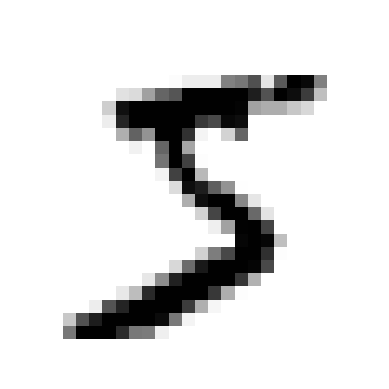

In [ ]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Training a Binary Classifier**

Mari kita sederhanakan masalahnya untuk saat ini dan coba identifikasi satu digit saja—misalnya angka 5. “Pendeteksi angka 5” ini akan menjadi contoh dari *binary classifier*, yaitu model yang mampu membedakan hanya dua kelas: 5 dan bukan-5. Mari kita buat vektor target untuk tugas klasifikasi ini:

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

**Performance Measures**

Measuring Accuracy Using Cross-Validation

Mengevaluasi sebuah *classifier* sering kali jauh lebih rumit dibandingkan mengevaluasi sebuah *regressor*, jadi kita akan menghabiskan sebagian besar bab ini untuk membahas topik tersebut. Terdapat banyak metrik performa yang tersedia, jadi silakan ambil secangkir kopi lagi dan bersiaplah mempelajari banyak konsep dan singkatan baru!

In [ ]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Akurasi di atas 93% (rasio prediksi yang benar) pada semua lipatan *cross-validation*? Ini terlihat luar biasa, bukan? Tapi, sebelum kita terlalu bersemangat, mari kita lihat sebuah *classifier* yang sangat sederhana—yang hanya mengklasifikasikan setiap gambar ke dalam kelas “bukan-5”.

In [ ]:
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
  return self
 def predict(self, X):
  return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()

In [ ]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Confusion Matrix**

Cara yang jauh lebih baik untuk mengevaluasi performa sebuah *classifier* adalah dengan melihat *confusion matrix*. Gagasan utamanya adalah menghitung berapa kali instance dari kelas A diklasifikasikan sebagai kelas B. Misalnya, untuk mengetahui berapa kali *classifier* salah mengenali gambar angka 5 sebagai angka 3, kita cukup melihat pada baris kelima dan kolom ketiga dari *confusion matrix*.

Untuk menghitung *confusion matrix*, kita pertama-tama perlu memiliki serangkaian prediksi agar dapat dibandingkan dengan target yang sebenarnya. Kita bisa saja membuat prediksi pada *test set*, tetapi untuk saat ini sebaiknya tetap kita biarkan utuh (ingat bahwa kita hanya akan menggunakan *test set* di akhir proyek, setelah memiliki *classifier* yang siap diluncurkan). Sebagai gantinya, kita bisa menggunakan fungsi `cross_val_predict()`:


In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5

In [ ]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**

Scikit-Learn menyediakan beberapa fungsi untuk menghitung metrik dari sebuah *classifier*, termasuk *precision* (presisi) dan *recall* (daya tangkap):

In [ ]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

**Precision/Recall Trade-of**

Scikit-Learn tidak memungkinkan kita untuk langsung mengatur ambang batas (*threshold*), tetapi memberikan akses ke skor keputusan (*decision scores*) yang digunakan untuk membuat prediksi. Alih-alih memanggil metode `predict()` dari *classifier*, kita bisa memanggil metode `decision_function()`, yang akan mengembalikan skor untuk setiap instance. Kemudian kita bisa menggunakan ambang batas apa pun yang kita inginkan untuk membuat prediksi berdasarkan skor tersebut:


In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

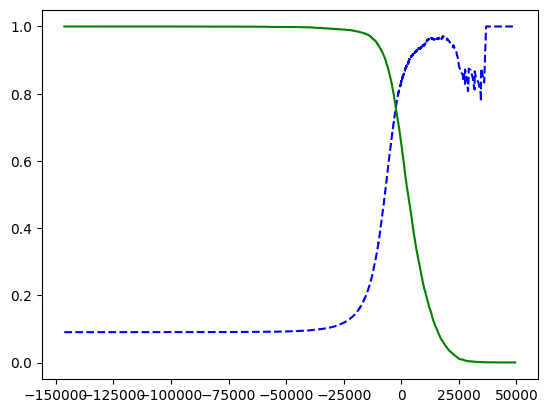

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Kita bisa lihat bahwa presisi mulai turun drastis saat recall mencapai sekitar 80%. Maka, kemungkinan besar kita ingin memilih titik kompromi presisi/recall tepat sebelum penurunan tersebut—misalnya, di sekitar 60% recall. Namun tentu saja, pilihan ini bergantung pada proyek yang sedang dikerjakan.

Misalkan kita memutuskan untuk menargetkan presisi sebesar 90%. Kita bisa melihat grafik pertama dan menemukan bahwa kita perlu menggunakan ambang batas sekitar 8.000. Untuk lebih tepatnya, kita bisa mencari ambang batas terendah yang memberikan setidaknya 90% presisi (`np.argmax()` akan memberikan indeks pertama dari nilai maksimum, yang dalam hal ini berarti nilai `True` pertama):


In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Hebat, sekarang kita memiliki *classifier* dengan presisi 90%! Seperti yang bisa kita lihat, cukup mudah membuat *classifier* dengan presisi setinggi apa pun yang kita inginkan: cukup atur ambang batas yang sangat tinggi, dan selesai. Tapi tunggu dulu, jangan terlalu cepat. *Classifier* dengan presisi tinggi tidak terlalu berguna jika recall-nya terlalu rendah!

**The ROC Curve**

Kurva ROC (*Receiver Operating Characteristic*) adalah alat umum lainnya yang digunakan untuk *binary classifier*. Kurva ini sangat mirip dengan kurva presisi/recall, tetapi alih-alih memplot presisi terhadap recall, kurva ROC memplot *true positive rate* (TPR, atau disebut juga recall) terhadap *false positive rate* (FPR).

FPR adalah rasio instance negatif yang secara salah diklasifikasikan sebagai positif. Ini sama dengan 1 dikurangi *true negative rate* (TNR), yaitu rasio instance negatif yang diklasifikasikan dengan benar sebagai negatif. TNR juga disebut *specificity* (spesifisitas). Jadi, kurva ROC memplot *sensitivity* (recall) terhadap 1 – specificity.

Untuk memplot kurva ROC, pertama kita gunakan fungsi `roc_curve()` untuk menghitung nilai TPR dan FPR berdasarkan berbagai ambang batas:

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--')

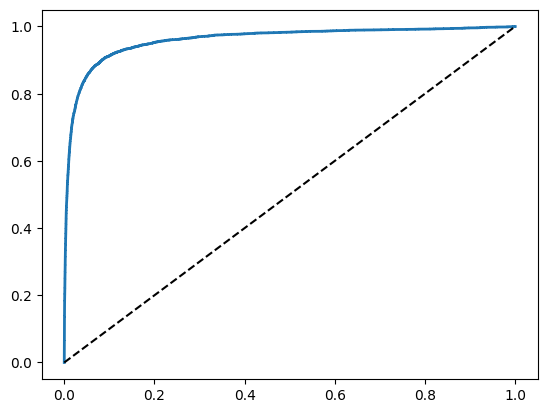

In [ ]:
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

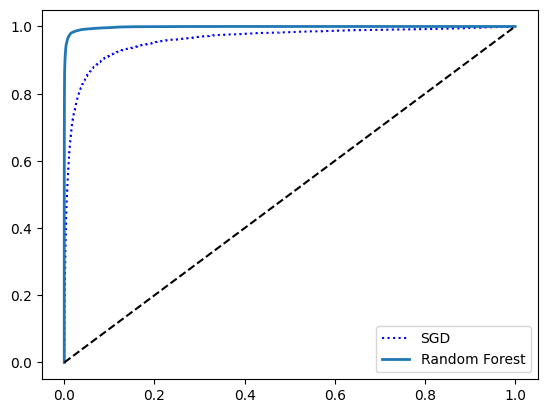

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

**Multiclass Classification**

Sementara *binary classifier* membedakan antara dua kelas, *multiclass classifier* (juga disebut *multinomial classifier*) mampu membedakan lebih dari dua kelas.

Beberapa algoritma (seperti *SGD classifier*, *Random Forest classifier*, dan *Naive Bayes classifier*) secara bawaan mampu menangani banyak kelas. Namun, algoritma lain (seperti *Logistic Regression* atau *Support Vector Machine classifier*) secara ketat hanya merupakan *binary classifier*.

Meski begitu, ada berbagai strategi yang bisa kita gunakan untuk melakukan klasifikasi multikelas dengan menggunakan beberapa *binary classifier*.


In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

np.int64(5)

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

np.uint8(5)

In [ ]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Model ini mendapatkan akurasi lebih dari 87% pada semua *test fold*. Jika kita menggunakan *classifier* acak, kita hanya akan mendapatkan akurasi sekitar 10%, jadi ini bukan hasil yang buruk. Namun, kita masih bisa meningkatkan performanya. Cukup dengan melakukan *scaling* pada input (seperti yang dibahas di Bab 2), akurasi dapat meningkat hingga lebih dari 89%:


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

**Error Analysis**

Jika ini adalah proyek nyata, sekarang kita akan mengikuti langkah-langkah dalam daftar periksa proyek *Machine Learning* (lihat Lampiran B). Kita akan mengeksplorasi opsi persiapan data, mencoba berbagai model (menyusun daftar pendek model terbaik dan menyetel *hyperparameter*-nya menggunakan `GridSearchCV`), serta mengotomatisasi sebanyak mungkin prosesnya.

Namun dalam kasus ini, kita akan mengasumsikan bahwa kita telah menemukan model yang menjanjikan dan ingin mencari cara untuk meningkatkannya. Salah satu caranya adalah dengan menganalisis jenis kesalahan yang dibuat oleh model tersebut.


In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

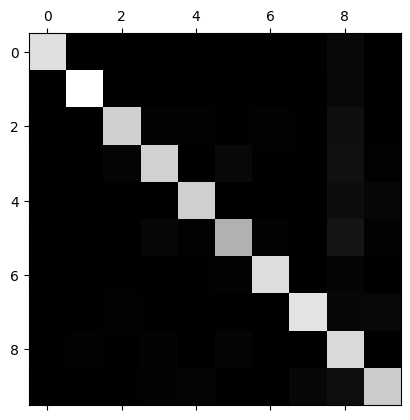

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

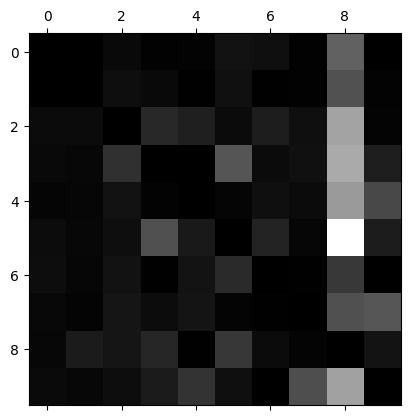

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)

    images = [instance.reshape(size, size) for instance in instances]

    n_rows = (len(instances) - 1) // images_per_row + 1

    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))

    image = np.concatenate(row_images, axis=0)

    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

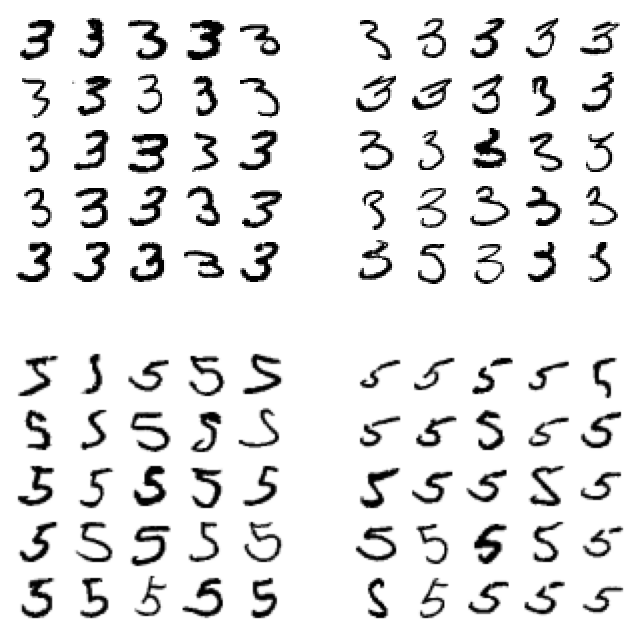

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221);
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

**Multilabel Classification**

Sampai sekarang, setiap instance selalu diberikan hanya ke satu kelas saja. Dalam beberapa kasus, kita mungkin ingin classifier kita mengeluarkan beberapa kelas untuk setiap instance. Bayangkan sebuah classifier pengenalan wajah: apa yang harus dilakukan jika ia mengenali beberapa orang dalam gambar yang sama? Ia seharusnya memberikan satu tag untuk setiap orang yang dikenalnya. Misalnya, classifier tersebut telah dilatih untuk mengenali tiga wajah, yaitu Alice, Bob, dan Charlie. Maka ketika classifier ditunjukkan gambar yang berisi Alice dan Charlie, ia harus mengeluarkan \[1, 0, 1] (artinya “Alice ya, Bob tidak, Charlie ya”). Sistem klasifikasi seperti ini yang mengeluarkan beberapa tag biner disebut sistem klasifikasi multilabel. Kita belum akan membahas pengenalan wajah sekarang, tapi mari kita lihat contoh yang lebih sederhana, hanya untuk tujuan ilustrasi.


In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

**Multioutput Classification**

Jenis tugas klasifikasi terakhir yang akan kita bahas di sini disebut klasifikasi multioutput multiclass (atau cukup disebut klasifikasi multioutput). Ini sebenarnya adalah generalisasi dari klasifikasi multilabel di mana setiap label dapat berupa multiclass (artinya, dapat memiliki lebih dari dua nilai kemungkinan).

Untuk mengilustrasikan hal ini, mari kita buat sebuah sistem yang menghilangkan noise dari gambar. Sistem ini akan menerima input berupa gambar digit yang berisik, dan (semoga) menghasilkan output berupa gambar digit yang bersih, yang direpresentasikan sebagai array intensitas piksel, sama seperti gambar MNIST. Perhatikan bahwa output dari classifier ini adalah multilabel (satu label per piksel) dan setiap label dapat memiliki banyak nilai (intensitas piksel berkisar dari 0 sampai 255). Dengan demikian, ini adalah contoh sistem klasifikasi multioutput.

Mari kita mulai dengan membuat set pelatihan dan pengujian dengan mengambil gambar MNIST dan menambahkan noise pada intensitas pikselnya menggunakan fungsi randint() dari NumPy. Gambar targetnya adalah gambar asli:


In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Predicting data on the index: 0


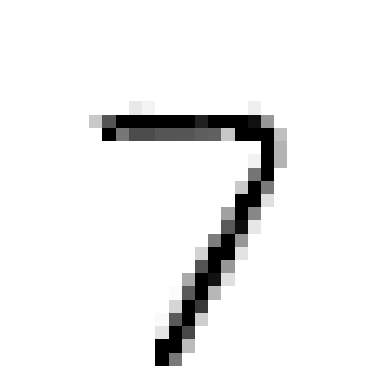

Real image:


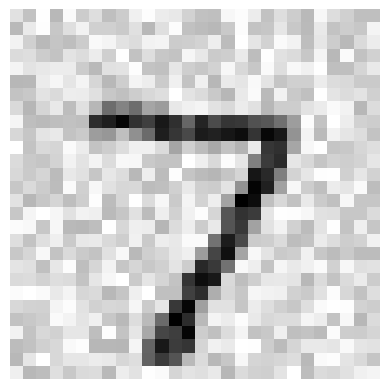

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

some_index = 0

print(f"Predicting data on the index: {some_index}")
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)
plt.show()


print("Real image:")
plot_digit(X_test_mod[some_index])
plt.show()

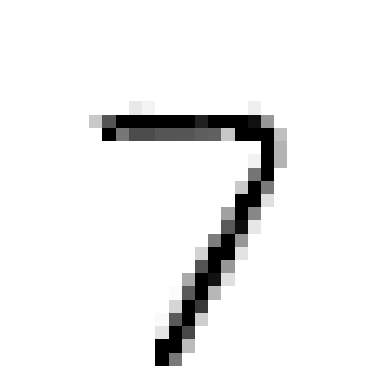

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Sudah cukup mendekati target! Ini mengakhiri pembahasan kita tentang klasifikasi. Sekarang kita seharusnya sudah tahu cara memilih metrik yang tepat untuk tugas klasifikasi, menentukan trade-off precision/recall yang sesuai, membandingkan classifier, dan secara umum membangun sistem klasifikasi yang baik untuk berbagai jenis tugas.